# Disease Prediction using Machine Learning Algorithms

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [4]:
!pip install catboost

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import math
import warnings
import os
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix ,classification_report
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Ignore FutureWarnings from Scikit-Learn
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Set TensorFlow logging level to suppress debug info
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Loading Data

#### Main Dataset

In [6]:
df = pd.read_csv('/content/drive/MyDrive/MasterThesis/dataset/dataset_modified.csv')
print(df.head())


            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches       NaN       NaN       NaN       NaN       NaN   
1            joint_pain       NaN       NaN       NaN       NaN       NaN   
2                   NaN       NaN       NaN       NaN       NaN       NaN   
3                   NaN       NaN       NaN       NaN       NaN       NaN   
4                   NaN       NaN       NaN       NaN       NaN       NaN   

  Symptom_10 Symptom_11 Symptom_12 Symptom_13 Symp

#### Symptom Severity Dataset

In [7]:
df1 = pd.read_csv('/content/drive/MyDrive/MasterThesis/dataset/Symptom-severity.csv')
print(df1.head())

                Symptom  weight
0               itching       1
1             skin_rash       3
2  nodal_skin_eruptions       4
3   continuous_sneezing       4
4             shivering       5


#### Symptom Description Dataset

In [8]:
df2 = pd.read_csv('/content/drive/MyDrive/MasterThesis/dataset/symptom_Description.csv')
print(df2.head())

          Disease                                        Description
0   Drug Reaction  An adverse drug reaction (ADR) is an injury ca...
1         Malaria  An infectious disease caused by protozoan para...
2         Allergy  An allergy is an immune system response to a f...
3  Hypothyroidism  Hypothyroidism, also called underactive thyroi...
4       Psoriasis  Psoriasis is a common skin disorder that forms...


#### Symptom Precaution Dataset

In [9]:
df3 = pd.read_csv('/content/drive/MyDrive/MasterThesis/dataset/symptom_precaution.csv')
print(df3.head())

          Disease                      Precaution_1  \
0   Drug Reaction                   stop irritation   
1         Malaria          Consult nearest hospital   
2         Allergy                    apply calamine   
3  Hypothyroidism                     reduce stress   
4       Psoriasis  wash hands with warm soapy water   

                   Precaution_2        Precaution_3  \
0      consult nearest hospital    stop taking drug   
1               avoid oily food  avoid non veg food   
2       cover area with bandage                 NaN   
3                      exercise         eat healthy   
4  stop bleeding using pressure      consult doctor   

                  Precaution_4  
0                    follow up  
1           keep mosquitos out  
2  use ice to compress itching  
3             get proper sleep  
4                   salt baths  


#### List of Diseases

In [10]:
diseases = set(df['Disease'])

print(diseases)
print('\n There are {} diseases described in the dataset'.format(len(diseases)))



{'Hypothyroidism', 'Hepatitis B', 'AIDS', 'Chronic cholestasis', 'Pneumonia', 'Allergy', 'Heart attack', 'Gastroenteritis', 'Hypoglycemia', 'Hepatitis C', 'Urinary tract infection', 'Fungal infection', 'Jaundice', 'Dengue', 'Cervical spondylosis', 'Bronchial Asthma', 'Paralysis (brain hemorrhage)', 'Hepatitis E', 'Tuberculosis', 'Hypertension ', 'Hyperthyroidism', '(vertigo) Paroymsal  Positional Vertigo', 'Peptic ulcer diseae', 'Typhoid', 'Impetigo', 'Migraine', 'Malaria', 'Chicken pox', 'Common Cold', 'Arthritis', 'Drug Reaction', 'Alcoholic hepatitis', 'Hepatitis D', 'Dimorphic hemmorhoids(piles)', 'Osteoarthristis', 'GERD', 'Diabetes ', 'hepatitis A', 'Acne', 'Psoriasis', 'Varicose veins'}

 There are 41 diseases described in the dataset


#### List of symptoms

In [11]:
symptoms = set(df.iloc[:,1:].values.flatten())

print(symptoms)
print('\nThere are {} symptoms described in the dataset'.format(len(symptoms) - 1))

{' loss_of_appetite', ' cold_hands_and_feets', ' inflammatory_nails', ' muscle_pain', ' neck_pain', ' headache', ' joint_pain', ' palpitations', ' visual_disturbances', ' weight_loss', ' anxiety', ' weight_gain', ' muscle_wasting', ' weakness_of_one_body_side', ' small_dents_in_nails', ' watering_from_eyes', ' sunken_eyes', ' rusty_sputum', ' knee_pain', ' runny_nose', ' restlessness', ' obesity', ' irritability', ' red_spots_over_body', ' acute_liver_failure', ' blood_in_sputum', ' distention_of_abdomen', ' sweating', ' ulcers_on_tongue', ' constipation', ' extra_marital_contacts', ' increased_appetite', ' muscle_weakness', ' receiving_unsterile_injections', ' blackheads', ' dark_urine', ' stomach_pain', ' swollen_legs', ' pain_during_bowel_movements', ' coma', ' swollen_blood_vessels', ' redness_of_eyes', ' spinning_movements', ' acidity', ' hip_joint_pain', ' indigestion', ' enlarged_thyroid', ' yellowing_of_eyes', ' mucoid_sputum', ' bloody_stool', ' phlegm', ' blurred_and_distorte

### Data Preprocessing

##### Handling Missing data

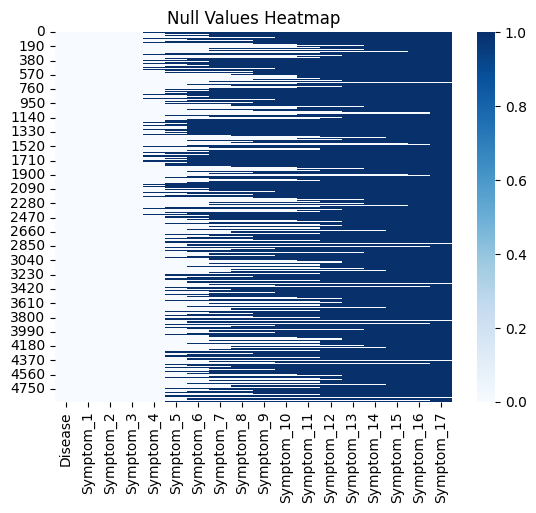

In [12]:
sns.heatmap(df.isnull(), cmap='Blues')
plt.title('Null Values Heatmap')
plt.show()


In [13]:
df.shape

(4920, 18)

In [14]:
df.isnull().sum()


,0
Disease,0
Symptom_1,0
Symptom_2,0
Symptom_3,0
Symptom_4,347
Symptom_5,1206
Symptom_6,1986
Symptom_7,2652
Symptom_8,2976
Symptom_9,3228


In [15]:
df = df.apply(lambda x: x.str.strip() )
df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: x.str.lower() )
df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: x.str.replace(' ', ''))


df = df.fillna(0)

symptoms = list(set(df.iloc[:,1:].values.flatten()))
symptoms.remove(0)

df

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic_patches,joint_pain,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,itching,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,itching,skin_rash,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,vomiting,headache,nausea,spinning_movements,loss_of_balance,unsteadiness,0,0,0,0,0,0,0,0,0,0,0
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,0,0,0,0,0,0,0,0,0,0,0,0,0
4917,Urinary tract infection,burning_micturition,bladder_discomfort,foul_smell_ofurine,continuous_feel_of_urine,0,0,0,0,0,0,0,0,0,0,0,0,0
4918,Psoriasis,skin_rash,joint_pain,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,0,0,0,0,0,0,0,0,0,0,0


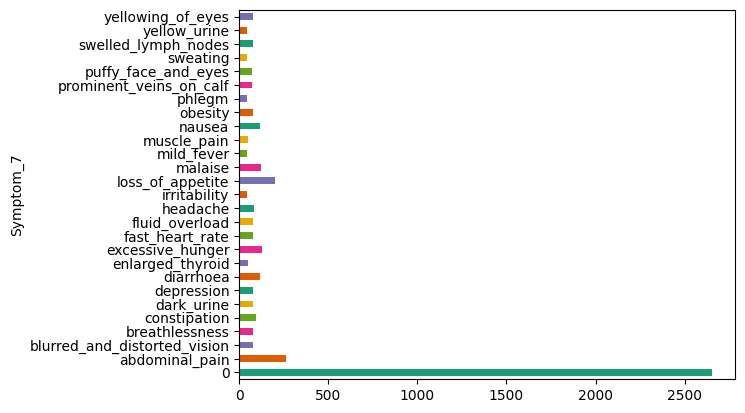

In [16]:
# @title Symptom_7

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Symptom_7').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(True)

##### Encoding  the symptoms with their severity weight

In [17]:
# Create a dictionary mapping each symptom to its severity
severity_map = dict(zip(df1['Symptom'], df1['weight']))

# replace the symptoms  with their severity
encoded_df =df.replace(severity_map)

encoded_df

<ipython-input-17-e747ab93b852>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_df =df.replace(severity_map)


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,1,3,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,3,4,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,1,4,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,1,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,1,3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,(vertigo) Paroymsal Positional Vertigo,5,3,5,6,4,4,0,0,0,0,0,0,0,0,0,0,0
4916,Acne,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0
4917,Urinary tract infection,6,4,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0
4918,Psoriasis,3,3,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0


#### Storing the diseases and encoded symptoms in seperate dataframes

In [18]:
cols = df.columns

(encoded_df[cols] == 0).all()

encoded_df['Disease'].value_counts()

encoded_df['Disease'].unique()

data = encoded_df.iloc[:,1:].values
labels = encoded_df['Disease'].values

#### Splitting the data


In [19]:

# First, split into training and temp (test + validation)
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, train_size=0.7, shuffle=True, random_state=42)

# Then split the temp set into test and validation
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

# Output the shapes of the resulting arrays
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape)


(3444, 17) (738, 17) (3444,) (738,) (738, 17) (738,)





## Model Training and Testing

In [20]:
# First, split into training and temp (test + validation)
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, train_size=0.7, shuffle=True, random_state=42)

# Then split the temp set into test and validation
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

# Output the shapes of the resulting arrays
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape)

# Encode the labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

(3444, 17) (738, 17) (3444,) (738,) (738, 17) (738,)


### Decision Tree Classifier

In [37]:
# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree model
dt.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = dt.score(x_train, y_train_encoded)
dt_test_score = dt.score(x_test, y_test_encoded)
val_score = dt.score(x_val, y_val_encoded)
print("Train accuracy:", train_score)
print("Test accuracy:", dt_test_score)
print("Validation accuracy:", val_score)

# Optionally, you can print a detailed classification report
dt_y_pred = dt.predict(x_test)
dt_accuracy_score = accuracy_score(y_test_encoded, dt_y_pred) * 100
print(classification_report(y_test_encoded, dt_y_pred))

Train accuracy: 0.9927409988385598
Test accuracy: 0.994579945799458
Validation accuracy: 0.991869918699187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        17
          15       1.00     

### Naive Bayes Classifier

In [39]:
# Initialize the Gaussian Naive Bayes classifier
nb = GaussianNB()

# Train the Gaussian Naive Bayes model
nb.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = nb.score(x_train, y_train_encoded)
nb_test_score = nb.score(x_test, y_test_encoded)
val_score = nb.score(x_val, y_val_encoded)

print("Train accuracy:", train_score)
print("Test accuracy:", nb_test_score)
print("Validation accuracy:", val_score)

# Optionally, you can print a detailed classification report
nb_y_pred = nb.predict(x_test)
nb_accuracy_score = accuracy_score(y_test_encoded, nb_y_pred) * 100

print(classification_report(y_test_encoded, nb_y_pred))

Train accuracy: 0.8777584204413472
Test accuracy: 0.8685636856368564
Validation accuracy: 0.8482384823848238
              precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.65      1.00      0.78        20
           2       1.00      1.00      1.00        22
           3       1.00      0.68      0.81        22
           4       0.76      0.76      0.76        17
           5       1.00      0.54      0.70        13
           6       1.00      0.75      0.86        20
           7       0.74      0.67      0.70        21
           8       1.00      1.00      1.00        12
           9       1.00      0.94      0.97        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      0.65      0.79        20
          14       1.00      0.59      0.74        17
          15       0.57   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SVC Classifier

In [40]:
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel type
}

# Initialize the SVC classifier
svc = SVC()

# Initialize GridSearchCV to search over the parameter grid
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train the model with GridSearchCV
grid_search.fit(x_train, y_train_encoded)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model
best_model = grid_search.best_estimator_
train_score = best_model.score(x_train, y_train_encoded)
svc_test_score = best_model.score(x_test, y_test_encoded)
val_score = best_model.score(x_val, y_val_encoded)

print("Train accuracy:", train_score)
print("Test accuracy:", svc_test_score)
print("Validation accuracy:", val_score)

# Print a detailed classification report
svc_y_pred = best_model.predict(x_test)
svc_accuracy_score = accuracy_score(y_test_encoded, svc_y_pred) * 100

print(classification_report(y_test_encoded, svc_y_pred))


Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score: 0.9912900394910048
Train accuracy: 0.9927409988385598
Test accuracy: 0.994579945799458
Validation accuracy: 0.991869918699187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00

### Weighted KNN Classifier

In [41]:
# Initialize the weighted KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Train the weighted KNN model
knn.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = knn.score(x_train, y_train_encoded)
knn_test_score = knn.score(x_test, y_test_encoded)
val_score = knn.score(x_val, y_val_encoded)

print("Train accuracy:", train_score)
print("Test accuracy:", knn_test_score)
print("Validation accuracy:", val_score)

# Optionally, you can print a detailed classification report
knn_y_pred = knn.predict(x_test)
knn_accuracy_score = accuracy_score(y_test_encoded, knn_y_pred) * 100
print("KNN Accuracy:",knn_accuracy_score)
print(classification_report(y_test_encoded, knn_y_pred))

Train accuracy: 0.9915795586527294
Test accuracy: 0.997289972899729
Validation accuracy: 0.9932249322493225
KNN Accuracy: 99.7289972899729
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00       

### Boost Classifiers (Ansemble learning)

#### Random Forest

Train accuracy: 0.9927409988385598
Test accuracy: 0.994579945799458
Validation accuracy: 0.991869918699187
Accuracy% = 99.45799457994579
F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.00      1.00        20
          14       1.00

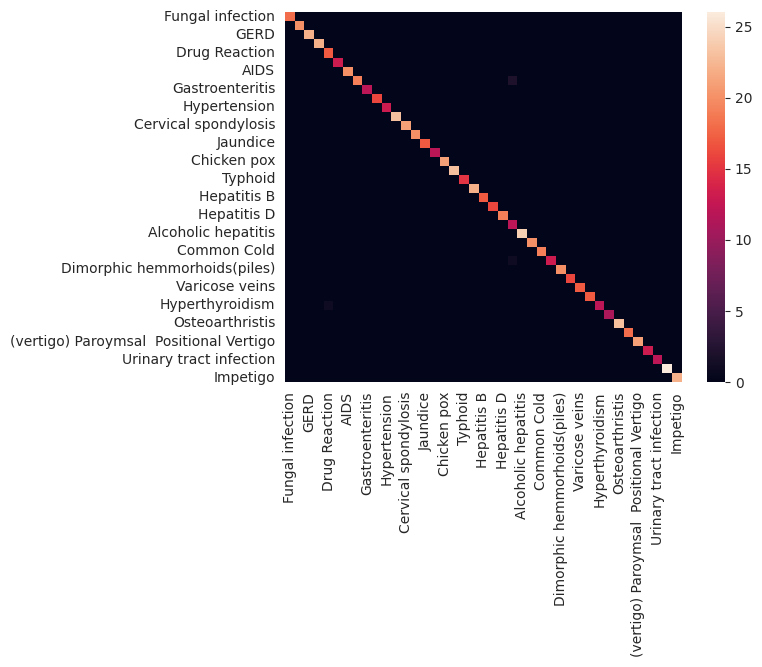

In [55]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the Random Forest model
rf.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = rf.score(x_train, y_train_encoded)
test_score = rf.score(x_test, y_test_encoded)
val_score = rf.score(x_val, y_val_encoded)

print("Train accuracy:", train_score)
print("Test accuracy:", test_score)
print("Validation accuracy:", val_score)



# Optionally, you can print a detailed classification report
rf_y_pred = rf.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, rf_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())

sns.heatmap(df_cm)

rf_accuracy_score = accuracy_score(y_test_encoded, rf_y_pred) * 100

print( 'Accuracy% =', rf_accuracy_score)
print('F1 Score =', f1_score(y_test_encoded, rf_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, rf_y_pred))


#### XGBoost

XGBoost Train accuracy: 0.9927409988385598
XGBoost Test accuracy: 0.994579945799458
XGBoost Validation accuracy: 0.991869918699187
XGBoost Accuracy% = 99.45799457994579
XGBoost F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.00    

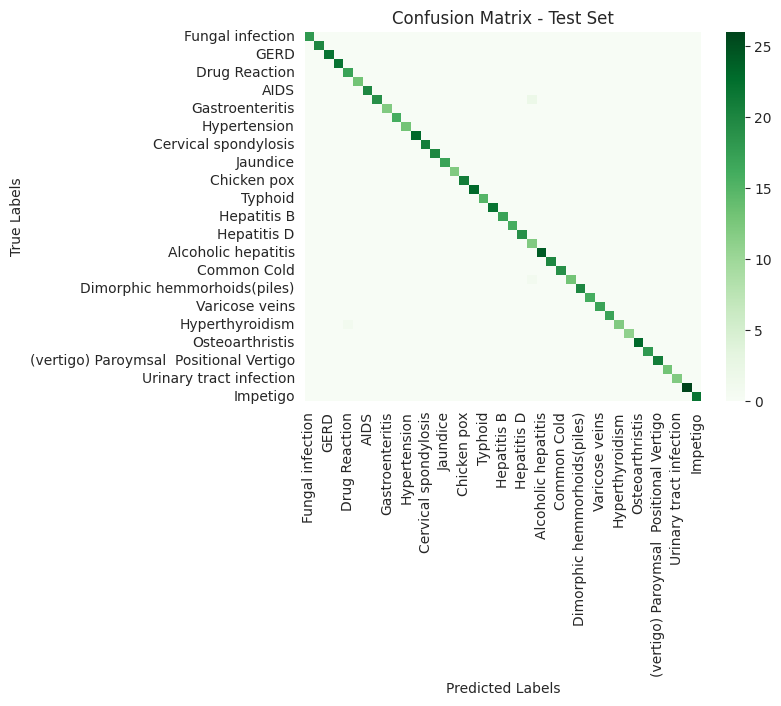

In [58]:

# Initialize the XGBoost classifier
xgb = XGBClassifier()

# Train the XGBoost model
xgb.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = xgb.score(x_train, y_train_encoded)
test_score = xgb.score(x_test, y_test_encoded)
val_score = xgb.score(x_val, y_val_encoded)

print("XGBoost Train accuracy:", train_score)
print("XGBoost Test accuracy:", test_score)
print("XGBoost Validation accuracy:", val_score)

# Classification report and confusion matrix
xgb_y_pred = xgb.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, xgb_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
sns.heatmap(df_cm, annot=False,cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

xgb_accuracy_score = accuracy_score(y_test_encoded, xgb_y_pred) * 100
print('XGBoost Accuracy% =', xgb_accuracy_score)
print('XGBoost F1 Score =', f1_score(y_test_encoded, xgb_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, xgb_y_pred))


#### Light GBM Classifier

LightGBM Train accuracy: 0.9927409988385598
LightGBM Test accuracy: 0.994579945799458
LightGBM Validation accuracy: 0.991869918699187
LightGBM Accuracy% = 99.45799457994579
LightGBM F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.0

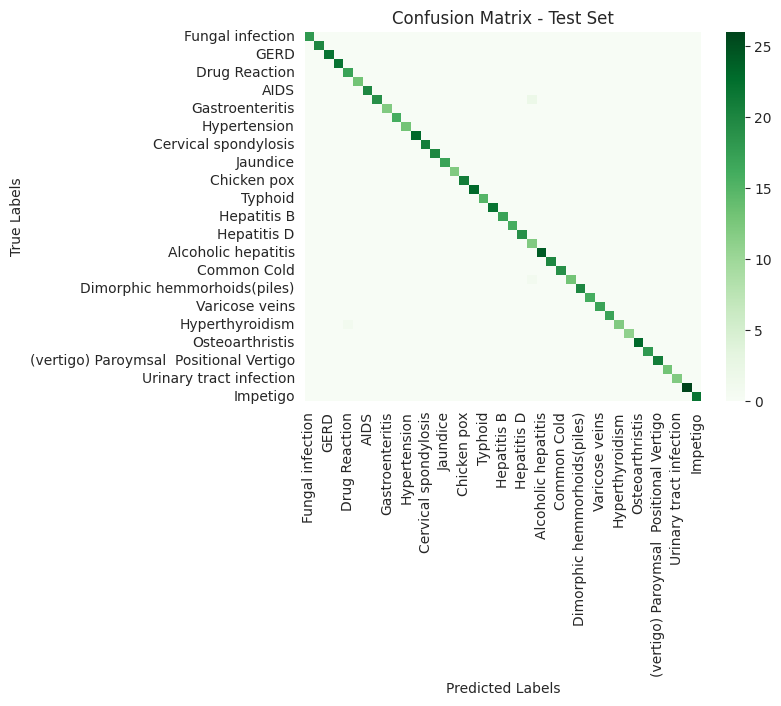

In [59]:

# Initialize the LightGBM classifier
lgbm = LGBMClassifier(verbose=-1)

# Train the LightGBM model
lgbm.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = lgbm.score(x_train, y_train_encoded)
test_score = lgbm.score(x_test, y_test_encoded)
val_score = lgbm.score(x_val, y_val_encoded)

print("LightGBM Train accuracy:", train_score)
print("LightGBM Test accuracy:", test_score)
print("LightGBM Validation accuracy:", val_score)

# Classification report and confusion matrix
lgbm_y_pred = lgbm.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, lgbm_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
sns.heatmap(df_cm, annot=False,cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

lgbm_accuracy_score = accuracy_score(y_test_encoded, lgbm_y_pred) * 100
print('LightGBM Accuracy% =', lgbm_accuracy_score)
print('LightGBM F1 Score =', f1_score(y_test_encoded, lgbm_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, lgbm_y_pred))


#### Cat Boost Classifier

CatBoost Train accuracy: 0.9927409988385598
CatBoost Test accuracy: 0.994579945799458
CatBoost Validation accuracy: 0.991869918699187
CatBoost Accuracy% = 99.45799457994579
CatBoost F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.00      1.0

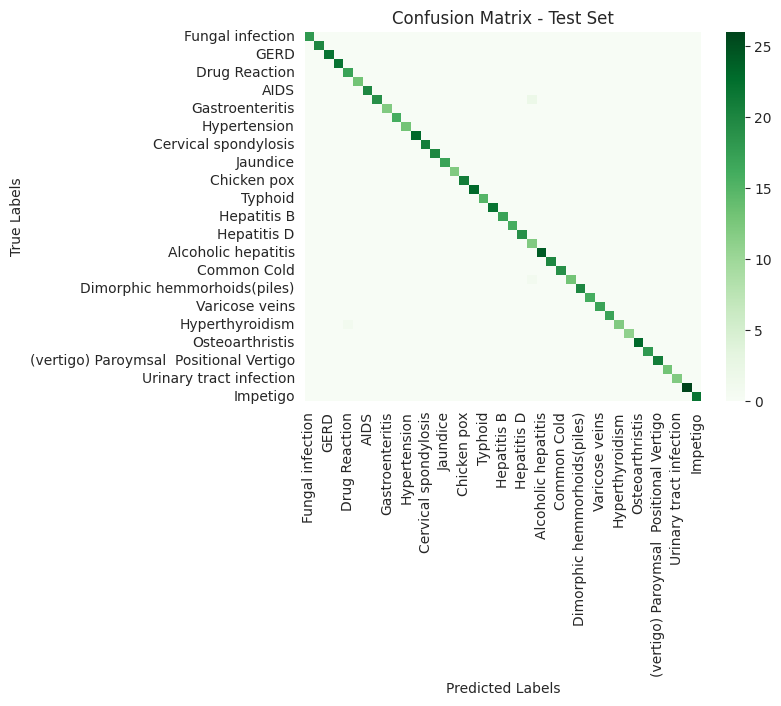

In [60]:

# Initialize the CatBoost classifier
catboost = CatBoostClassifier(silent=True)

# Train the CatBoost model
catboost.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = catboost.score(x_train, y_train_encoded)
test_score = catboost.score(x_test, y_test_encoded)
val_score = catboost.score(x_val, y_val_encoded)

print("CatBoost Train accuracy:", train_score)
print("CatBoost Test accuracy:", test_score)
print("CatBoost Validation accuracy:", val_score)

# Classification report and confusion matrix
catboost_y_pred = catboost.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, catboost_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
sns.heatmap(df_cm, annot=False,cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

catboost_accuracy_score = accuracy_score(y_test_encoded, catboost_y_pred) * 100
print('CatBoost Accuracy% =', catboost_accuracy_score)
print('CatBoost F1 Score =', f1_score(y_test_encoded, catboost_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, catboost_y_pred))


#### Gradient Boost Classifier

GradientBoost Train accuracy: 0.9927409988385598
GradientBoost Test accuracy: 0.994579945799458
GradientBoost Validation accuracy: 0.991869918699187
GradientBoost Accuracy% = 99.45799457994579
GradientBoost F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
       

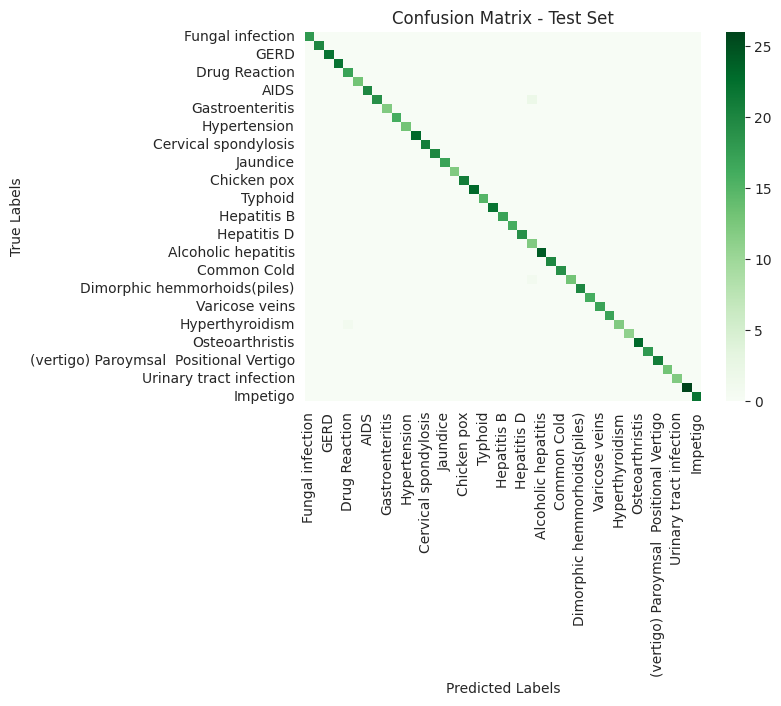

In [61]:

# Initialize the Gradient Boosting classifier
gb = GradientBoostingClassifier()

# Train the Gradient Boosting model
gb.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = gb.score(x_train, y_train_encoded)
test_score = gb.score(x_test, y_test_encoded)
val_score = gb.score(x_val, y_val_encoded)

print("GradientBoost Train accuracy:", train_score)
print("GradientBoost Test accuracy:", test_score)
print("GradientBoost Validation accuracy:", val_score)

# Classification report and confusion matrix
gb_y_pred = gb.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, gb_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
sns.heatmap(df_cm, annot=False,cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

gb_accuracy_score = accuracy_score(y_test_encoded, gb_y_pred) * 100
print('GradientBoost Accuracy% =', gb_accuracy_score)
print('GradientBoost F1 Score =', f1_score(y_test_encoded, gb_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, gb_y_pred))


#### Extra Trees Classifier

ExtraTrees Train accuracy: 0.9927409988385598
ExtraTrees Test accuracy: 0.994579945799458
ExtraTrees Validation accuracy: 0.991869918699187
ExtraTrees Accuracy% = 99.45799457994579
ExtraTrees F1 Score = 99.47051949355472
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.00      1.00      1.00        12
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        21
          13       1.0

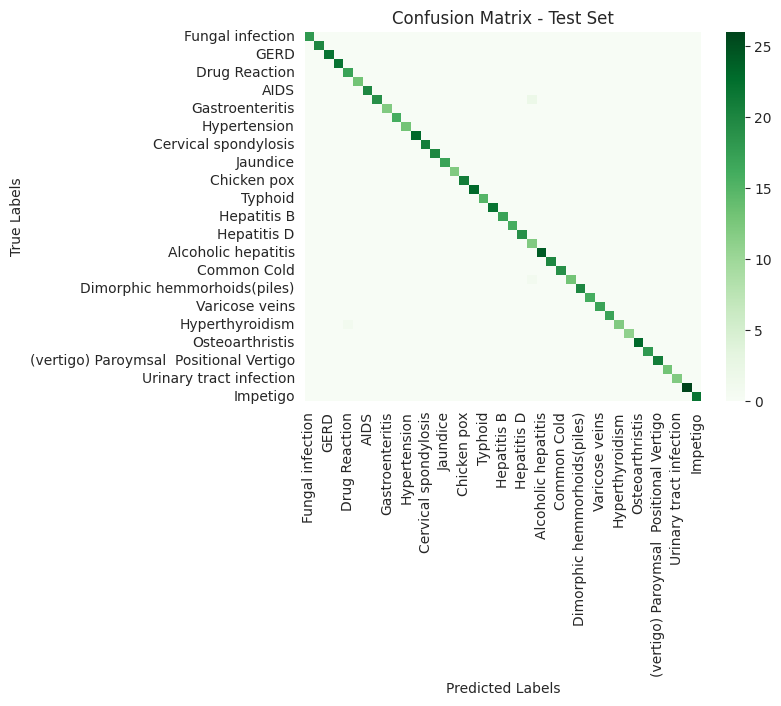

In [63]:

# Initialize the Extra Trees classifier
et = ExtraTreesClassifier()

# Train the Extra Trees model
et.fit(x_train, y_train_encoded)

# Evaluate the model
train_score = et.score(x_train, y_train_encoded)
test_score = et.score(x_test, y_test_encoded)
val_score = et.score(x_val, y_val_encoded)

print("ExtraTrees Train accuracy:", train_score)
print("ExtraTrees Test accuracy:", test_score)
print("ExtraTrees Validation accuracy:", val_score)

# Classification report and confusion matrix
et_y_pred = et.predict(x_test)
conf_mat = confusion_matrix(y_test_encoded, et_y_pred)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
sns.heatmap(df_cm, annot=False,cmap='Greens')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

et_accuracy_score = accuracy_score(y_test_encoded, et_y_pred) * 100
print('ExtraTrees Accuracy% =', et_accuracy_score)
print('ExtraTrees F1 Score =', f1_score(y_test_encoded, et_y_pred, average='weighted') * 100)
print(classification_report(y_test_encoded, et_y_pred))


## Hyper parameter Optimization with GridSearchCV

In [ ]:

param_grids = {
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    },
    'K Nearest Neighbours': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'Naive Bayes': {
        'var_smoothing': np.logspace(-9, 0, 10)
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'CatBoost': {
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'depth': [3, 5, 7]
    }
}

# Initialize classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42),
    'K Nearest Neighbours': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoost': CatBoostClassifier(random_state=42, silent=True)
}

# Perform GridSearchCV for each classifier
best_models = {}
for name, classifier in classifiers.items():
    print(f"Training {name} with GridSearchCV...")
    grid_search = GridSearchCV(estimator=classifier, param_grid=param_grids[name], cv=5, n_jobs=-1)
    grid_search.fit(x_train, y_train_encoded)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Parameters for {name}: {grid_search.best_params_}")
    print(f"Best Score for {name}: {grid_search.best_score_}")

# Evaluate the best models
for name, model in best_models.items():
    print(f"Evaluating {name}...")
    train_score = model.score(x_train, y_train_encoded)
    test_score = model.score(x_test, y_test_encoded)
    val_score = model.score(x_val, y_val_encoded)
    print(f"Train accuracy for {name}: {train_score}")
    print(f"Test accuracy for {name}: {test_score}")
    print(f"Validation accuracy for {name}: {val_score}")
    y_pred = model.predict(x_test)
    print(classification_report(y_test_encoded, y_pred))

Training Decision Tree with GridSearchCV...
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2}
Best Score for Decision Tree: 0.9915803152529786
Training Random Forest with GridSearchCV...
Best Parameters for Random Forest: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 10}
Best Score for Random Forest: 0.9918705910149527
Training SVC with GridSearchCV...
Best Parameters for SVC: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Best Score for SVC: 0.9912900394910048
Training K Nearest Neighbours with GridSearchCV...
Best Parameters for K Nearest Neighbours: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best Score for K Nearest Neighbours: 0.9921608667769265
Training Naive Bayes with GridSearchCV...
Best Parameters for Naive Bayes: {'var_smoothing': 0.01}
Best Score for Naive Bayes: 0.9277023492084921
Training Gradient Boosting with GridSearchCV...
Best Parameters for Gradient Boosting: 

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for LightGBM: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Best Score for LightGBM: 0.9915803152529786
Training CatBoost with GridSearchCV...
Best Parameters for CatBoost: {'depth': 7, 'iterations': 200, 'learning_rate': 0.2}
Best Score for CatBoost: 0.9912900394910048
Evaluating Decision Tree...
Train accuracy for Decision Tree: 0.9927409988385598
Test accuracy for Decision Tree: 0.994579945799458
Validation accuracy for Decision Tree: 0.991869918699187
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        22
           4       0.94      1.00      0.97        17
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        20
           7       1.00      0.90      0.95        21
           8       1.0

## Neural Network classifier

In [44]:
# One-hot encode the integer labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_onehot = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))
y_val_onehot = onehot_encoder.transform(y_val_encoded.reshape(-1, 1))

# Convert numpy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(x_test, dtype=tf.float32)
X_eval_tensor = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_onehot, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test_onehot, dtype=tf.float32)
y_eval_tensor = tf.convert_to_tensor(y_val_onehot, dtype=tf.float32)

# Number of unique classes in the labels
num_classes = y_train_onehot.shape[1]


### Dense Multilayer Neural Network with Keras

In [22]:

with tf.device('/GPU:0'):
    model_1 = keras.Sequential([
        layers.Input(shape=(X_train_tensor.shape[1],)),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(128, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='tanh'),
        layers.Dropout(0.1),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, mode='max')

    history = model_1.fit(X_train_tensor, y_train_tensor, epochs=70, callbacks=[early_stopping],
                          batch_size=16, validation_data=(X_eval_tensor, y_eval_tensor))

Epoch 1/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2083 - loss: 3.0980 - val_accuracy: 0.6409 - val_loss: 1.2038
Epoch 2/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7039 - loss: 0.9942 - val_accuracy: 0.8835 - val_loss: 0.4987
Epoch 3/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8157 - loss: 0.6185 - val_accuracy: 0.9228 - val_loss: 0.3073
Epoch 4/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8408 - loss: 0.5226 - val_accuracy: 0.9309 - val_loss: 0.2241
Epoch 5/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8859 - loss: 0.3754 - val_accuracy: 0.9322 - val_loss: 0.2240
Epoch 6/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8816 - loss: 0.3830 - val_accuracy: 0.9593 - val_loss: 0.1669
Epoch 7/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8801 - loss: 0.3671 - val_accuracy: 0.9797 - val_loss: 0.1007
Epoch 8/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8951 - loss: 0.3067 - val_accuracy: 0.

In [23]:
model_1.evaluate(X_test_tensor, y_test_tensor)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9904 - loss: 0.0430


[0.05686236172914505, 0.9823848009109497]

Training Accuracy: 0.9800
Test Accuracy: 0.9824
Validation Accuracy: 0.9797
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Multilayer Perceptron Accuracy% = 97.96747967479675

Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        88
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        79
           3       1.00      0.88      0.94        84
           4       1.00      0.87      0.93        85
           5       0.99      0.96      0.98        84
           6       0.88      0.95      0.91        76
           7       1.00      0.97      0.98        88
           8       1.00      1.00      1.00        85
           9       1.00      0.96      0.98        90
          10       1.00      1.00      1.00        89
          11       1.00      1.00      1.00        80
          

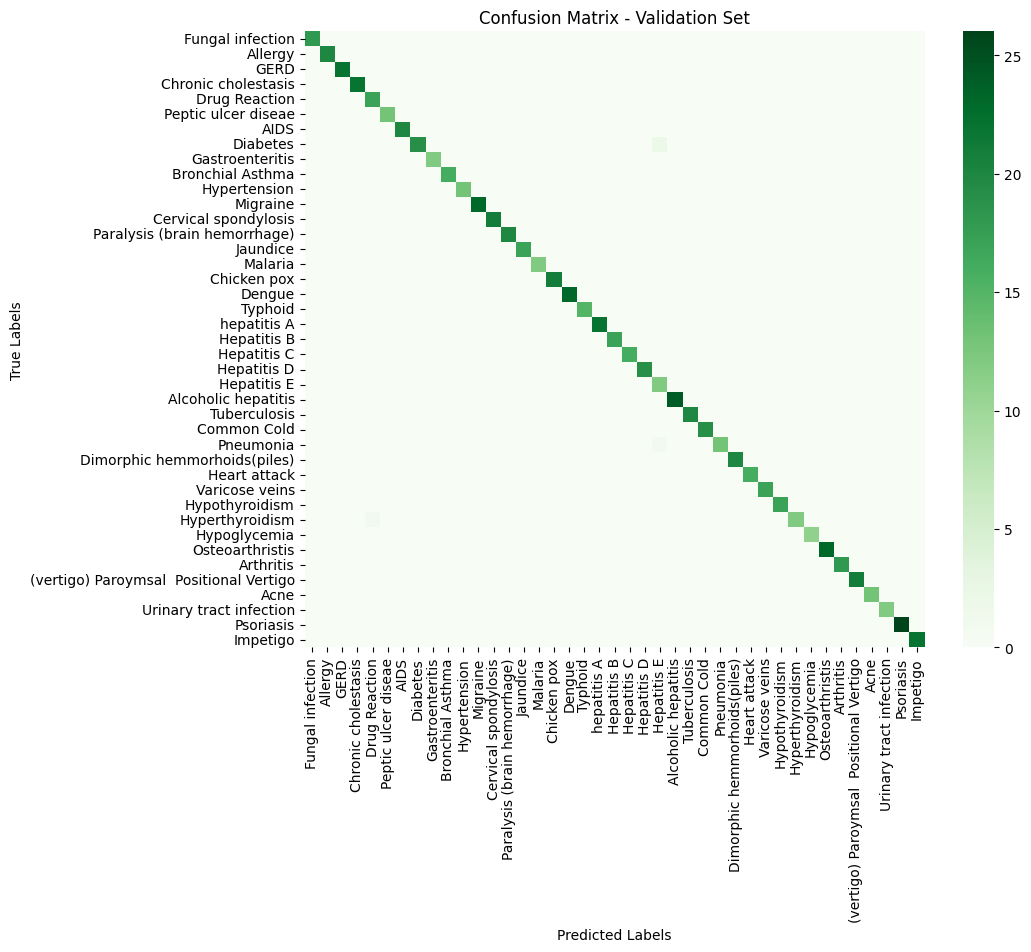

In [31]:
# Evaluate the model on training, test, and validation sets
train_score = model_1.evaluate(X_train_tensor, y_train_tensor, verbose=0)
test_score = model_1.evaluate(X_test_tensor, y_test_tensor, verbose=0)
val_score = model_1.evaluate(X_eval_tensor, y_eval_tensor, verbose=0)

print(f"Training Accuracy: {train_score[1]:.4f}")
print(f"Test Accuracy: {test_score[1]:.4f}")
print(f"Validation Accuracy: {val_score[1]:.4f}")

# Make predictions and convert them back from one-hot encoding to class labels
y_train_pred = model_1.predict(X_train_tensor).argmax(axis=1)
y_test_pred = model_1.predict(X_test_tensor).argmax(axis=1)
y_val_pred = model_1.predict(X_eval_tensor).argmax(axis=1)

# Convert true labels from one-hot encoding to class labels
y_train_true = y_train_encoded
y_test_true = y_test_encoded
y_val_true = y_val_encoded

# Calculate accuracy
MLP_accuracy_score = accuracy_score(y_val_true, y_val_pred) * 100

# Print overall accuracy score
print('Multilayer Perceptron Accuracy% =', MLP_accuracy_score)

# Detailed classification report
print("\nClassification Report - Training Set")
print(classification_report(y_train_true, y_train_pred))
print("\nClassification Report - Test Set")
print(classification_report(y_test_true, y_test_pred))
print("\nClassification Report - Validation Set")
print(classification_report(y_val_true, y_val_pred))

# Confusion Matrix for Validation Set
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())

sns.heatmap(df_cm,cmap='Greens')
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Train With LSTM

In [66]:
with tf.device('/GPU:0'):
    model_LSTM = keras.Sequential([
        layers.Input(shape=(x_train.shape[1], 1)), # Reshape the input to (17, 1)
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(128),
        layers.Dropout(0.1),
        layers.Dense(256, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='tanh'),
        layers.Dropout(0.1),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model_LSTM.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

    history = model_LSTM.fit(X_train_tensor, y_train_tensor, epochs=70, callbacks=[early_stopping],
                             batch_size=16, validation_data=(X_eval_tensor, y_eval_tensor))

Epoch 1/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.0985 - loss: 3.0754 - val_accuracy: 0.1843 - val_loss: 2.3243
Epoch 2/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2275 - loss: 2.2497 - val_accuracy: 0.1775 - val_loss: 2.9920
Epoch 3/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3540 - loss: 1.7575 - val_accuracy: 0.3672 - val_loss: 1.6924
Epoch 4/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.4042 - loss: 1.5956 - val_accuracy: 0.2805 - val_loss: 2.0537
Epoch 5/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.4909 - loss: 1.3661 - val_accuracy: 0.4688 - val_loss: 1.5245
Epoch 6/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.6071 - loss: 1.1120 - val_accuracy: 0.7995 - val_loss: 0.6539
Epoch 7/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.6812 - loss: 0.9117 - val_accuracy: 0.5786 - val_loss: 1.0857
Epoch 8/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6981 - loss: 0.8632 - val

In [67]:
model_LSTM.evaluate(X_test_tensor, y_test_tensor)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9692 - loss: 0.1317


[0.12620116770267487, 0.9634146094322205]

Training Accuracy: 0.9739
Test Accuracy: 0.9634
Validation Accuracy: 0.9715
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM Accuracy% = 97.15447154471545

Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        88
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        79
           3       1.00      0.80      0.89        84
           4       0.87      1.00      0.93        85
           5       1.00      1.00      1.00        84
           6       1.00      0.92      0.96        76
           7       0.99      0.97      0.98        88
           8       1.00      1.00      1.00        85
           9       1.00      1.00      1.00        90
          10       1.00      1.00      1.00        89
          11       1.00      1.00      1.00        80
          12       1.00   

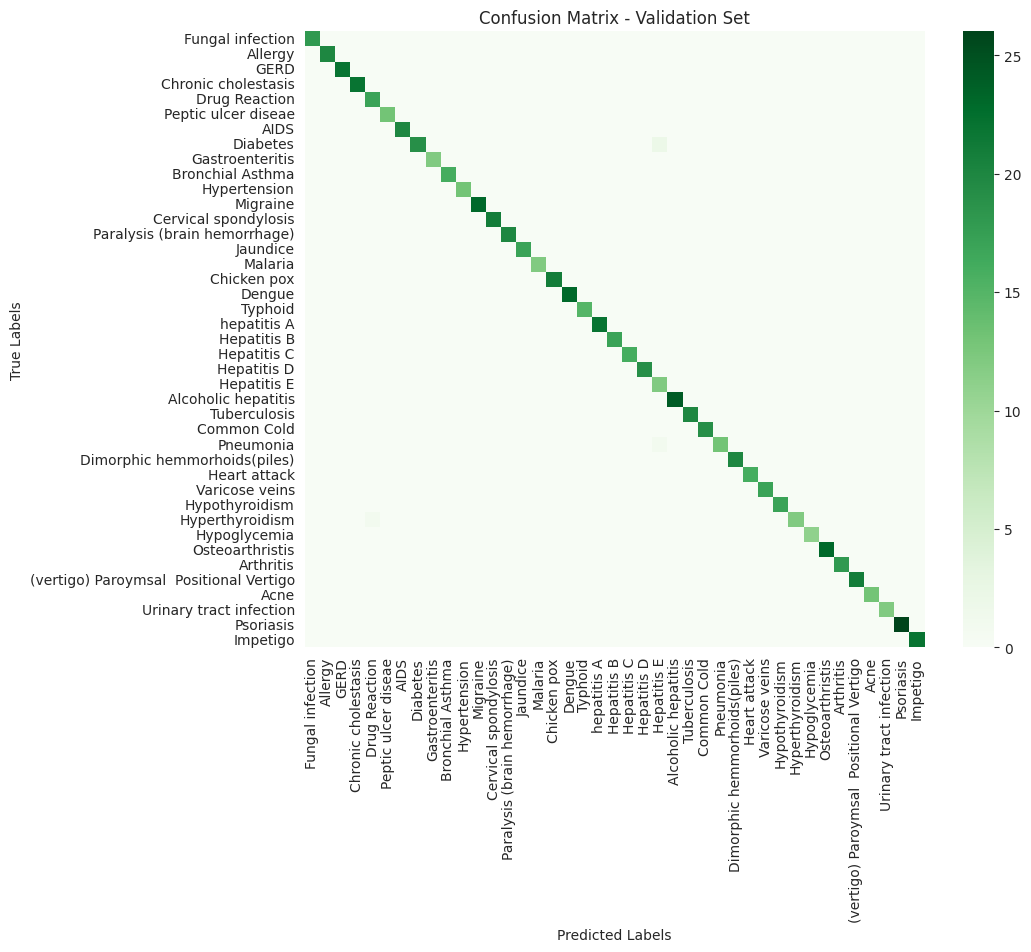

In [68]:
# Evaluate the model on training, test, and validation sets
LSTM_train_score = model_LSTM.evaluate(X_train_tensor, y_train_tensor, verbose=0)
LSTM_test_score = model_LSTM.evaluate(X_test_tensor, y_test_tensor, verbose=0)
LSTM_val_score = model_LSTM.evaluate(X_eval_tensor, y_eval_tensor, verbose=0)

print(f"Training Accuracy: {LSTM_train_score[1]:.4f}")
print(f"Test Accuracy: {LSTM_test_score[1]:.4f}")
print(f"Validation Accuracy: {LSTM_val_score[1]:.4f}")

# Make predictions and convert them back from one-hot encoding to class labels
LSTM_y_train_pred = model_LSTM.predict(X_train_tensor).argmax(axis=1)
LSTM_y_test_pred = model_LSTM.predict(X_test_tensor).argmax(axis=1)
LSTM_y_val_pred = model_LSTM.predict(X_eval_tensor).argmax(axis=1)

# Convert true labels from one-hot encoding to class labels
LSTM_y_train_true = y_train_encoded
LSTM_y_test_true = y_test_encoded
LSTM_y_val_true = y_val_encoded

# Calculate accuracy
LSTM_accuracy_score = accuracy_score(LSTM_y_val_true, LSTM_y_val_pred) * 100

# Print overall accuracy score
print('LSTM Accuracy% =', LSTM_accuracy_score)

# Detailed classification report
print("\nClassification Report - Training Set")
print(classification_report(LSTM_y_train_true, LSTM_y_train_pred))
print("\nClassification Report - Test Set")
print(classification_report(LSTM_y_test_true, LSTM_y_test_pred))
print("\nClassification Report - Validation Set")
print(classification_report(LSTM_y_val_true, LSTM_y_val_pred))

# Confusion Matrix for Validation Set
conf_matrix = confusion_matrix(LSTM_y_val_true, LSTM_y_val_pred)
plt.figure(figsize=(10, 8))
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())

sns.heatmap(df_cm,cmap='Greens')
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Train With GRU

In [70]:
# Building the model using GRU layers
with tf.device('/GPU:0'):
    model_GRU = keras.Sequential([
        layers.Input(shape=(x_train.shape[1], 1)), # Reshape the input to (17, 1)
        layers.Reshape((1, -1)),
        layers.GRU(32, return_sequences=True),
        layers.GRU(64),
        layers.Dropout(0.2),
        layers.Dense(128, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dense(128, activation='tanh'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, mode='max')
    history = model_GRU.fit(X_train_tensor, y_train_tensor, epochs=70, callbacks=[early_stopping],
                          batch_size=16, validation_data=(X_eval_tensor, y_eval_tensor))


Epoch 1/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2102 - loss: 2.9587 - val_accuracy: 0.6626 - val_loss: 1.6725
Epoch 2/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6696 - loss: 1.0550 - val_accuracy: 0.8347 - val_loss: 0.6111
Epoch 3/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7774 - loss: 0.6965 - val_accuracy: 0.8821 - val_loss: 0.3698
Epoch 4/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8472 - loss: 0.5004 - val_accuracy: 0.9173 - val_loss: 0.2916
Epoch 5/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8659 - loss: 0.4175 - val_accuracy: 0.9295 - val_loss: 0.2627
Epoch 6/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8619 - loss: 0.4329 - val_accuracy: 0.9377 - val_loss: 0.2071
Epoch 7/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8778 - loss: 0.3594 - val_accuracy: 0.9648 - val_loss: 0.1620
Epoch 8/70
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9043 - loss: 0.2967 - val_accura

In [71]:
model_GRU.evaluate(X_test_tensor, y_test_tensor)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9815 - loss: 0.0520


[0.06295926868915558, 0.9769647717475891]

Training Accuracy: 0.9791
Test Accuracy: 0.9770
Validation Accuracy: 0.9743
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
GRU Accuracy% = 97.42547425474255

Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        88
           1       1.00      1.00      1.00        81
           2       1.00      1.00      1.00        79
           3       1.00      0.94      0.97        84
           4       0.90      1.00      0.95        85
           5       0.99      0.96      0.98        84
           6       0.93      0.91      0.92        76
           7       0.97      0.97      0.97        88
           8       1.00      1.00      1.00        85
           9       1.00      1.00      1.00        90
          10       1.00      1.00      1.00        89
          11       1.00      1.00      1.00        80
          12       1.00      

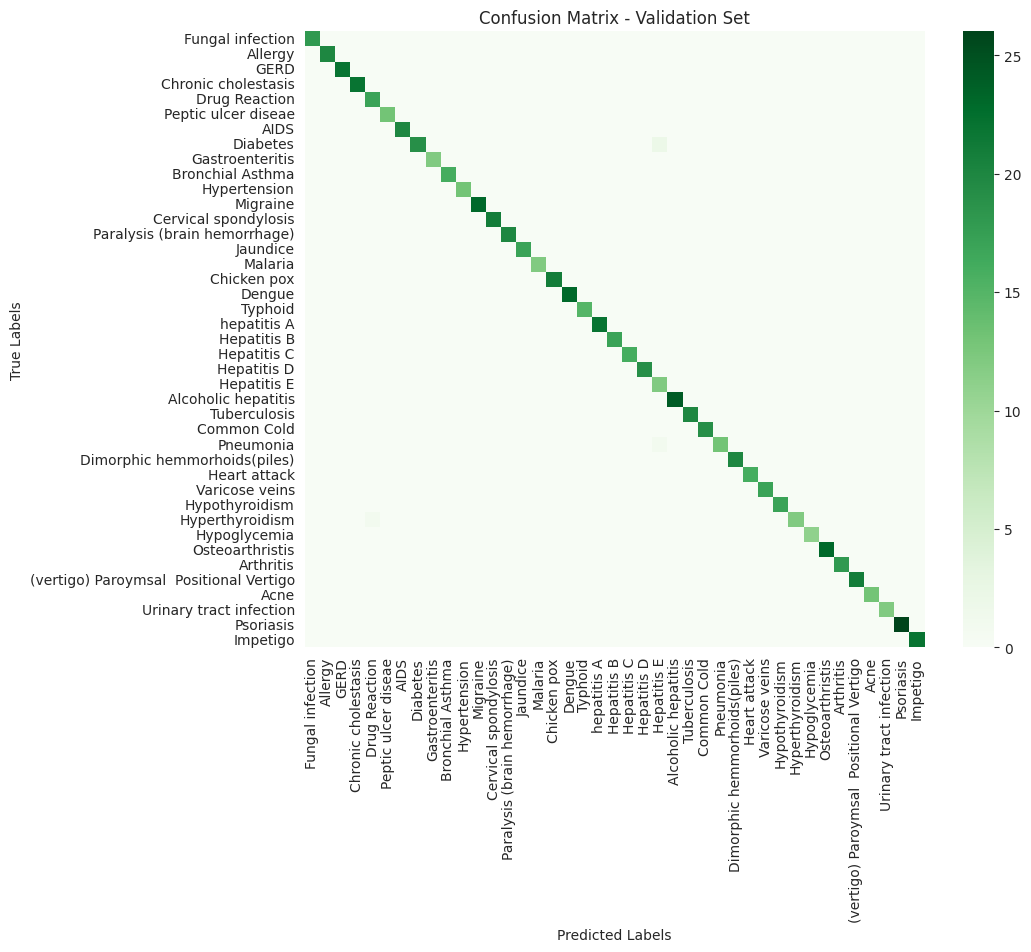

In [72]:
# Evaluate the model on training, test, and validation sets
GRU_train_score = model_GRU.evaluate(X_train_tensor, y_train_tensor, verbose=0)
GRU_test_score = model_GRU.evaluate(X_test_tensor, y_test_tensor, verbose=0)
GRU_val_score = model_GRU.evaluate(X_eval_tensor, y_eval_tensor, verbose=0)

print(f"Training Accuracy: {GRU_train_score[1]:.4f}")
print(f"Test Accuracy: {GRU_test_score[1]:.4f}")
print(f"Validation Accuracy: {GRU_val_score[1]:.4f}")

# Make predictions and convert them back from one-hot encoding to class labels
GRU_y_train_pred = model_GRU.predict(X_train_tensor).argmax(axis=1)
GRU_y_test_pred = model_GRU.predict(X_test_tensor).argmax(axis=1)
GRU_y_val_pred = model_GRU.predict(X_eval_tensor).argmax(axis=1)

# Convert true labels from one-hot encoding to class labels
GRU_y_train_true = y_train_encoded
GRU_y_test_true = y_test_encoded
GRU_y_val_true = y_val_encoded

# Calculate accuracy
GRU_accuracy_score = accuracy_score(GRU_y_val_true, GRU_y_val_pred) * 100

# Print overall accuracy score
print('GRU Accuracy% =', GRU_accuracy_score)

# Detailed classification report
print("\nClassification Report - Training Set")
print(classification_report(GRU_y_train_true, GRU_y_train_pred))
print("\nClassification Report - Test Set")
print(classification_report(GRU_y_test_true, GRU_y_test_pred))
print("\nClassification Report - Validation Set")
print(classification_report(GRU_y_val_true, GRU_y_val_pred))

# Confusion Matrix for Validation Set
conf_matrix = confusion_matrix(GRU_y_val_true, GRU_y_val_pred)
plt.figure(figsize=(10, 8))
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())

sns.heatmap(df_cm,cmap='Greens')
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [35]:
X_train_tensor

<tf.Tensor: shape=(3444, 17), dtype=float32, numpy=
array([[3., 4., 4., ..., 0., 0., 0.],
       [3., 4., 4., ..., 0., 0., 0.],
       [3., 7., 4., ..., 0., 0., 0.],
       ...,
       [3., 3., 3., ..., 0., 0., 0.],
       [1., 3., 4., ..., 0., 0., 0.],
       [1., 3., 5., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
y_train_tensor

<tf.Tensor: shape=(3444, 41), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Comparing the accuracy of all the models

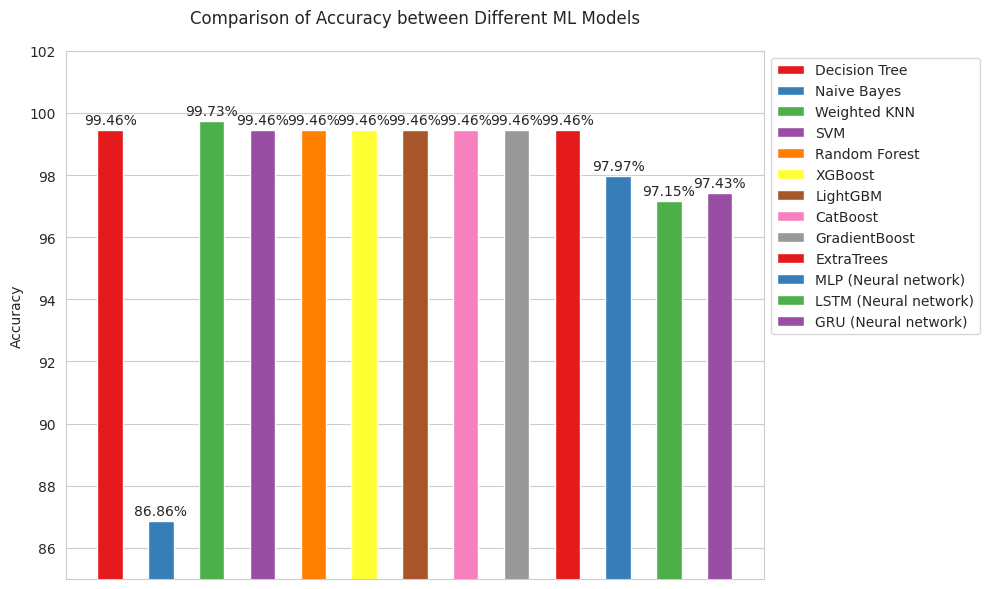

In [74]:
models = ['Decision Tree',  'Naive Bayes', 'Weighted KNN', 'SVM','Random Forest', 'XGBoost', 'LightGBM', 'CatBoost',
          'GradientBoost', 'ExtraTrees','MLP (Neural network)','LSTM (Neural network)','GRU (Neural network)']
accuracies = [dt_accuracy_score, nb_accuracy_score, knn_accuracy_score, svc_accuracy_score,rf_accuracy_score, xgb_accuracy_score,lgbm_accuracy_score,
              catboost_accuracy_score, gb_accuracy_score, et_accuracy_score,MLP_accuracy_score,LSTM_accuracy_score,GRU_accuracy_score]

# Set the style
sns.set_style("whitegrid")

# Define the colors for each bar
colors = sns.color_palette("Set1", len(models))

# Create the figure and axis with an appropriate figure size
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width as needed

# Define the width of the bars
bar_width = 0.5

# Create the bar positions to ensure bars are closer
bar_positions = np.arange(len(models))

# Create the bars with individual colors
bars = ax.bar(bar_positions, accuracies, bar_width, color=colors, align='center')

# Add the accuracy value on top of each bar
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.2, f'{accuracy:.2f}%', ha='center')

# Set the limits, labels, and title
plt.ylim(85, 102)
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy between Different ML Models",pad=20)

# Remove the x-axis labels
ax.set_xticks([])

# Add a legend with colors matching the bars
ax.legend(bars, models, loc='upper left', bbox_to_anchor=(1, 1))

# Adjust the layout to fit the legend
plt.tight_layout()

# Display the plot
plt.show()


In [85]:
import plotly.graph_objects as go
import plotly.express as px
# Define the models and accuracies
models = [
    'Decision Tree', 'Naive Bayes', 'Weighted KNN', 'SVM', 'Random Forest', 'MLP (Neural network)',
    'LSTM (Neural network)', 'GRU (Neural network)'
]
accuracies = [
    dt_accuracy_score, nb_accuracy_score, knn_accuracy_score, svc_accuracy_score,
    rf_accuracy_score, MLP_accuracy_score, LSTM_accuracy_score,
    GRU_accuracy_score
]

# Define the color palette
colors = px.colors.qualitative.Dark24

# Create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=models,
    y=accuracies,
    text=[f'{accuracy:.2f}%' for accuracy in accuracies],  # Add accuracy text
    textposition='auto',
    marker=dict(color=colors)  # Set colors for bars
))

# Update layout
fig.update_layout(
    title="Comparison of Accuracy between Different ML Models",
    xaxis_title="Machine Learning Models",
    yaxis_title="Accuracy (%)",
    yaxis=dict(range=[85, 102]),  # Set y-axis range
    template="plotly_white",
    legend_title="Models",
    width=1000,
    height=600
)

# Display the plot
fig.show()


### Making Predictions

In [99]:
# Retrieve the disease names from the label encoder
disease_names = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

def predict_disease(symptoms_list, model, top_k=5):
    # Encode the symptoms based on their severity
    encoded_symptoms = [severity_map[symptom] for symptom in symptoms_list]

    for i in range(len(encoded_symptoms), 17):
        encoded_symptoms.append(0)

    # Create a numpy array from the encoded symptoms
    symptoms_array = np.array(encoded_symptoms).reshape(1, -1)

    # Use the trained model to predict the probabilities of all diseases
    disease_probs = model.predict_proba(symptoms_array)[0]

    # Sort the predicted probabilities in descending order
    sorted_probs_idx = np.argsort(disease_probs)[::-1]

    # Get the top-k predicted diseases and their probabilities with disease names
    top_k_diseases = [(disease_names[idx], round(disease_probs[idx], 2)) for idx in sorted_probs_idx[:top_k]]

    return top_k_diseases

Predicted diseases with probabilities: [('Fungal infection', 1.0), ('hepatitis A', 0.0), ('Hepatitis B', 0.0), ('Gastroenteritis', 0.0), ('GERD', 0.0)]


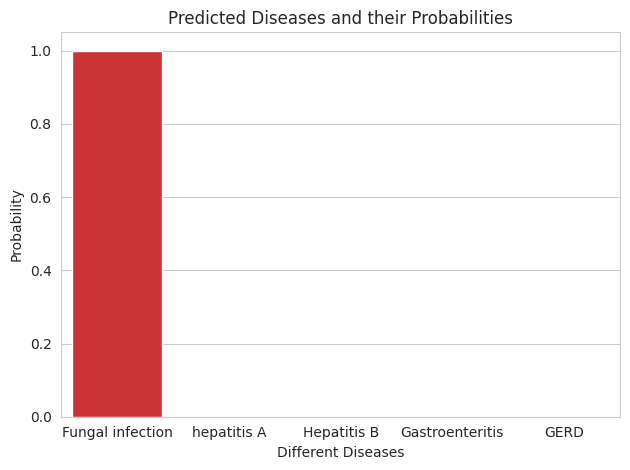

In [101]:


def output_predicted_diseases(symptoms_list, model, top_k=5):
    top_k_diseases = predict_disease(symptoms_list, model, top_k)

    # Display each disease and probability as a tuple in a list format
    print("Predicted diseases with probabilities:", top_k_diseases)

    # Optional: Plot the results
    predict_diseases = [disease[0] for disease in top_k_diseases]
    predict_probs = [disease[1] for disease in top_k_diseases]

    sns.set_style("whitegrid")
    sns.set_palette("Set1")
    sns.barplot(x=predict_diseases, y=predict_probs)

    plt.xlabel("Different Diseases")
    plt.ylabel("Probability")
    plt.title("Predicted Diseases and their Probabilities")
    plt.tight_layout()
    plt.show()

# Example Test
symptomsList = ['itching', 'skin_peeling', 'skin_rash']
output_predicted_diseases(symptomsList, knn, top_k=5)


Predicted diseases with probabilities: [('Fungal infection', 0.5), ('Acne', 0.2), ('Chronic cholestasis', 0.1), ('Jaundice', 0.1), ('Allergy', 0.1)]


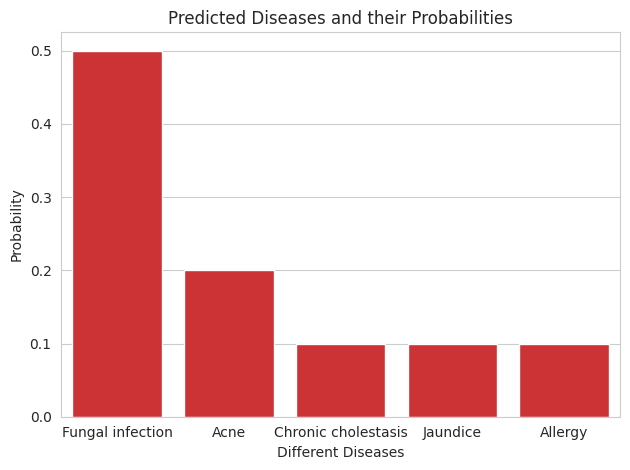

In [102]:
# Example Test
symptomsList = ['itching', 'skin_peeling', 'skin_rash']
output_predicted_diseases(symptomsList, rf, top_k=5)

Predicted diseases with probabilities: [('Fungal infection', 1.0), ('hepatitis A', 0.0), ('Hepatitis B', 0.0), ('Gastroenteritis', 0.0), ('GERD', 0.0)]


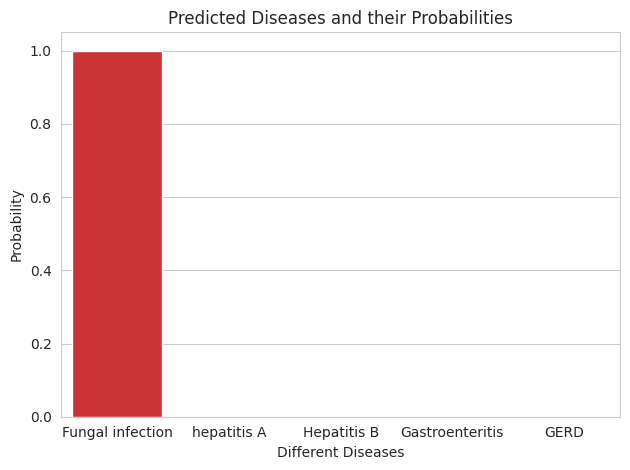

In [106]:
# Example Test
symptomsList = ['itching', 'skin_peeling', 'skin_rash']
output_predicted_diseases(symptomsList, dt, top_k=5)

In [ ]:
# Example Test
symptomsList = ['itching', 'skin_peeling', 'skin_rash']
output_predicted_diseases(symptomsList, nb, top_k=5)

### Deploying Trained Model

In [113]:
with open('/content/drive/MyDrive/MasterThesis/models/DecisionTreeClassifier.plk', 'wb') as file:
      pickle.dump(dt, file)

with open('/content/drive/MyDrive/MasterThesis/models/RandomForestClassifier.plk', 'wb') as file:
    pickle.dump(rf, file)

with open('/content/drive/MyDrive/MasterThesis/models/XGBoostClassifier.plk', 'wb') as file:
      pickle.dump(xgb, file)

with open('/content/drive/MyDrive/MasterThesis/models/LightGBM.plk', 'wb') as file:
      pickle.dump(lgbm, file)

with open('/content/drive/MyDrive/MasterThesis/models/GradientBoostingClassifier.plk', 'wb') as file:
      pickle.dump(gb, file)

with open('/content/drive/MyDrive/MasterThesis/models/ExtraTreesClassifier.plk', 'wb') as file:
      pickle.dump(et, file)


with open('/content/drive/MyDrive/MasterThesis/models/GaussianNB.plk', 'wb') as file:
      pickle.dump(nb, file)

with open('/content/drive/MyDrive/MasterThesis/models/KNeighborsClassifier.plk', 'wb') as file:
      pickle.dump(knn, file)

with open('/content/drive/MyDrive/MasterThesis/models/SVC.plk', 'wb') as file:
      pickle.dump(svc, file)
with open('/content/drive/MyDrive/MasterThesis/models/MLP.plk', 'wb') as file:
      pickle.dump(model_1, file)

with open('/content/drive/MyDrive/MasterThesis/models/LSTM.plk', 'wb') as file:
      pickle.dump(model_LSTM, file)

with open('/content/drive/MyDrive/MasterThesis/models/GRU.plk', 'wb') as file:
      pickle.dump(model_GRU, file)


with open('/content/drive/MyDrive/MasterThesis/models/symptoms.plk', 'wb') as file:
      pickle.dump(symptoms, file)

with open('/content/drive/MyDrive/MasterThesis/models/severity_map.plk', 'wb') as f:
    pickle.dump(severity_map, f)

precaution_dict = {}

for row in df3.values:
    precaution_dict[row[0]] = row[1:]

with open('/content/drive/MyDrive/MasterThesis/models/precaution_dict.plk', 'wb') as f:
    pickle.dump(precaution_dict, f)